### Install

In [863]:
#pip install ucimlrepo

### Imports

In [864]:
# Imports
from ucimlrepo import fetch_ucirepo
import pandas as pd
import psycopg2
from collections import defaultdict
from scipy import stats as kl
from decimal import Decimal
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from itertools import product

In [865]:
connection = psycopg2.connect(database="Project645", user="vaishnavishah", password="10jan2001", host="localhost", port=5432)
#connection = psycopg2.connect(database="Project645", user="postgres", password="Rajada1234@", host="localhost", port=5433)
#connection = psycopg2.connect(database="seedb", user="postgres", password="nineten910", host="localhost", port=5432)
cursor = connection.cursor()


In [866]:
# checking execution
query = "select workclass from married limit 5;"

cursor.execute(query)
record = cursor.fetchall()
print(record)

[('Self-emp-not-inc',), ('Private',), ('Private',), ('Private',), ('Private',)]


In [867]:
aggregation_functions = ['avg', 'sum', 'max', 'min', 'count']
group_by_columns = [
    'workclass',
    'education',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native_country',
    'income'
]
measure_columns = [
    'age',
    'fnlwgt',
    'education_num',
    'capital_gain',
    'capital_loss',
    'hours_per_week'
]

In [868]:
# FORMULAS 
min_fl = np.finfo(float).eps

def kl_distance(target, reference):
    target = dict(target)
    reference = dict(reference)

    t = []
    r = []

    # We need this to ensure the same number of categories in each distribution
    for key in set().union(target.keys(), reference.keys()):
        t_val = float(target.get(key, 0))
        r_val = float(reference.get(key, 0))
        t.append(t_val)
        r.append(r_val)

    # Normalize to create a probability distribution
    t_sum = np.sum(t) or 1.0
    r_sum = np.sum(r) or 1.0
    t = np.asarray(t) / t_sum
    r = np.asarray(r) / r_sum
    t = np.maximum(t, min_fl)
    r = np.maximum(r, min_fl)

    entropy_cal = np.sum(t * np.log(t / r))

    return entropy_cal

def hoeffding_serfling_interval(phase, num_phases, delta):
    phase = float(phase)
    num_phases = float(phase)
    numerator = (1 - ((phase - 1) / num_phases)) * (2 * np.log(np.log(phase)) + np.log((np.pi * np.pi) / (3 * delta)))
    epsilon_m = np.sqrt(numerator / (2 * phase))
    return epsilon_m

In [869]:
# age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country

In [870]:
def calculate_top_k(cur, views_ls, top_k=5, verbose=False):
    results = list()
    query = "select {group}, {func}({m_col}) from {table} {where} group by {group};"
    for group, views in views_ls.items():
        for view in views:
            _, func, m_col = view
            target_query = query.format(group=group,
                                        func=func,
                                        m_col=m_col,
                                        table='married',
                                        where=""
                                        )

            cur.execute(target_query)
            target_results = cur.fetchall()

            reference_query = query.format(group=group,
                                           func=func,
                                           m_col=m_col,
                                           table='unmarried',
                                           where=""
                                           )
            cur.execute(reference_query)
            reference_results = cur.fetchall()
            #print('target ', target_results)
            #print('ref: ', reference_results)
            tmp_query = """
            SELECT COALESCE(t.{group}, r.{group}) AS {group},
                COALESCE(t.target_{func}_{m_col}, 0) AS target_{func}_{m_col},
                COALESCE(r.reference_{func}_{m_col}, 0) AS reference_{func}_{m_col}
            FROM (
                -- Target results
                SELECT {group}, {func}({m_col}) AS target_{func}_{m_col}
                FROM married
                where target_{func}_{m_col} != 0
                GROUP BY {group}
            ) AS t
            INNER JOIN (
                -- Reference results
                SELECT {group}, {func}({m_col}) AS reference_{func}_{m_col}
                FROM {table_reference}
                where reference_{func}_{m_col} != 0
                GROUP BY {group}
            ) AS r ON t.{group} = r.{group};
            """.format(
                group=group,
                func=func,
                m_col=m_col,
                where_target='',  
                table_reference='unmarried',
            )
            #print('combiend ', tmp_query)
            cur.execute(tmp_query)
            combined_results = cur.fetchall()
            #print(combined_results)
            target_results = [(group, target_measure) for group, target_measure, _ in combined_results]
            reference_results = [(group, ref_measure) for group, _, ref_measure in combined_results]

            #print('target ',target_results)
            #print('ref ',reference_results)
            dist = kl_distance(target_results, reference_results)
            #print(dist)
            results.append((view, dist))
            #print(results)
            if verbose:
                print ("{}, {}, {}".format(group, func, m_col), dist)
    return list(reversed(sorted(results, key=lambda x: x[1])))[:top_k]

In [871]:
# def naive_search(cur, views_ls, verbose=False):
#     top_k=5
#     grouped_views = defaultdict(list)

#     for view in views_ls:
#         grouper = view[0]
#         grouped_views[grouper].append(view)
#     print(grouped_views)
    
#     return calculate_top_k(cur, grouped_views, top_k, verbose)


In [872]:
views_ls = []
for a in group_by_columns:
    for f in aggregation_functions:
        for m in measure_columns:
            views_ls.append((a,f,m))

#naive_search(cursor, views_ls)

In [873]:
def create_results(df):
    data_tuples = []

    views_ls = []
    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Get the non-null value from the first 8 columns
        
        group = next((col, row[col])for col in row.index[:8] if row[col] is not None)
        
        values = [(col, row[col][0]) for col in row.index[8:]]
        for v in values:
            first_part, second_part = v[0].split('_', 1)
            view= [group[0],first_part, second_part,  group[1] ,v[1]]
            views_ls.append(view)

    # Initialize a defaultdict to store the tuples grouped by the first three columns
    grouped_tuples = defaultdict(set)

    # Iterate through the list of views
    for view in views_ls:
        # Get the first three elements of the view as a tuple (group_key)
        group_key = tuple(view[:3])
        # Get the value of the fourth column
        value = (view[3], view[4])
        # Append the value to the list corresponding to the group_key in the dictionary
        grouped_tuples[group_key].add(value)

    #Iterate through the dictionary and create a list of tuples with the same values in the first three columns
    list_of_views = []
    for group_key, values_list in grouped_tuples.items():
        #print(group_key, [(value[0], value[1]) for value in values_list])
        some_ls = [(value[0], value[1]) for value in values_list]
        list_of_views.append((group_key, some_ls))
        #result.extend([(value[0], value[1]) for value in values_list])

    return list_of_views


In [874]:
def k_sharing_based_query(cur, views):
    tables = ['married', 'unmarried']
    # combine multiple aggregates and multiple group-by
    select_a_str = []
    select_m_str = []
    group_by_str = []
    for (a,f,m) in views:
        select_a_str.append('{}'.format(a))
        select_m_str.append('{}({}) as {}_{}'.format(f, m, f, m))
        group_by_str.append('({})'.format(a))

    select_a_str = ', '.join(set(select_a_str))
    select_m_str = ', '.join(select_m_str)
    group_by_str = ', '.join(set(group_by_str))

    data = []
    for table in tables:
        query = """select {}, {} from {} group by grouping sets ({});""".format(select_a_str, select_m_str, table, group_by_str)
        print(query)
        cur.execute(query)
        data.append(cur.fetchall())
        print(data)
    cols = [desc[0] for desc in cur.description]


    
    views_ls = []
    for a in group_by_columns:
        for f in aggregation_functions:
            for m in measure_columns:
                views_ls.append((a,f,m))

    tgt_df = pd.DataFrame(data[0], columns=cols)
    ref_df = pd.DataFrame(data[1], columns=cols)

    list_of_views_tgt = create_results(tgt_df)
    list_of_views_ref = create_results(ref_df)

    results = []
    for i in range(len(list_of_views_tgt)):
        target_results = list_of_views_tgt[i][1]
        reference_results = list_of_views_ref[i][1]
        group, func, m_col = list_of_views_ref[i][0]
        #print(list_of_views_tgt[i][0])
        tmp_query = """
            SELECT COALESCE(t.{group}, r.{group}) AS {group},
                COALESCE(t.target_{func}_{m_col}, 0) AS target_{func}_{m_col},
                COALESCE(r.reference_{func}_{m_col}, 0) AS reference_{func}_{m_col}
            FROM (
                -- Target results
                SELECT {group}, {func}({m_col}) AS target_{func}_{m_col}
                FROM married
                GROUP BY {group}
            
            ) AS t
            INNER JOIN (
                -- Reference results
                SELECT {group}, {func}({m_col}) AS reference_{func}_{m_col}
                FROM {table_reference}
                GROUP BY {group}
                
            ) AS r ON t.{group} = r.{group};
            """.format(
                group=group,
                func=func,
                m_col=m_col,
                where_target='',  
                table_reference='unmarried',
            )
        cursor.execute(tmp_query)
        combined_results = cursor.fetchall()
        target_results = [(group, target_measure) for group, target_measure, _ in combined_results]
        reference_results = [(group, ref_measure) for group, _, ref_measure in combined_results]
        #print(target_results)
        dist = kl_distance(target_results, reference_results)
        #print(dist)
        results.append((list_of_views_tgt[i][0], dist))
    return list(reversed(sorted(results, key=lambda x: x[1])))[:5]

In [875]:
k_sharing_based_query(cursor, views_ls)

select relationship, race, income, workclass, occupation, sex, native_country, education, avg(age) as avg_age, avg(fnlwgt) as avg_fnlwgt, avg(education_num) as avg_education_num, avg(capital_gain) as avg_capital_gain, avg(capital_loss) as avg_capital_loss, avg(hours_per_week) as avg_hours_per_week, sum(age) as sum_age, sum(fnlwgt) as sum_fnlwgt, sum(education_num) as sum_education_num, sum(capital_gain) as sum_capital_gain, sum(capital_loss) as sum_capital_loss, sum(hours_per_week) as sum_hours_per_week, max(age) as max_age, max(fnlwgt) as max_fnlwgt, max(education_num) as max_education_num, max(capital_gain) as max_capital_gain, max(capital_loss) as max_capital_loss, max(hours_per_week) as max_hours_per_week, min(age) as min_age, min(fnlwgt) as min_fnlwgt, min(education_num) as min_education_num, min(capital_gain) as min_capital_gain, min(capital_loss) as min_capital_loss, min(hours_per_week) as min_hours_per_week, count(age) as count_age, count(fnlwgt) as count_fnlwgt, count(educatio

[[(None, None, None, None, None, None, 'Italy', None, Decimal('47.1095890410958904'), Decimal('180059.438356164384'), Decimal('8.4109589041095890'), Decimal('999.4931506849315068'), Decimal('75.7123287671232877'), Decimal('43.4931506849315068'), 3439, 13144339, 614, 72963, 5527, 3175, 77, 573583, 14, 20051, 1977, 80, 24, 37913, 2, 0, 0, 20, 73, 73, 73, 73, 73, 73, Decimal('47.1095890410958904'), Decimal('180059.438356164384'), Decimal('8.4109589041095890'), Decimal('999.4931506849315068'), Decimal('75.7123287671232877'), Decimal('43.4931506849315068'), 3439, 13144339, 614, 72963, 5527, 3175, 77, 573583, 14, 20051, 1977, 80, 24, 37913, 2, 0, 0, 20, 73, 73, 73, 73, 73, 73, Decimal('47.1095890410958904'), Decimal('180059.438356164384'), Decimal('8.4109589041095890'), Decimal('999.4931506849315068'), Decimal('75.7123287671232877'), Decimal('43.4931506849315068'), 3439, 13144339, 614, 72963, 5527, 3175, 77, 573583, 14, 20051, 1977, 80, 24, 37913, 2, 0, 0, 20, 73, 73, 73, 73, 73, 73, Decimal

/var/folders/06/r72grj251s36gjt22b7ykyyh0000gn/T/ipykernel_42195/3773259945.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values = [(col, row[col][0]) for col in row.index[8:]]


[(('native_country', 'avg', 'capital_loss'), 11.928380269525338),
 (('native_country', 'max', 'capital_loss'), 11.649641890739073),
 (('native_country', 'avg', 'capital_gain'), 7.367407353798934),
 (('occupation', 'avg', 'capital_loss'), 6.518833732947606),
 (('workclass', 'avg', 'capital_loss'), 4.891437460559657)]

In [861]:
def sharing_based_search(cur, views_ls, top_k=5, verbose=False):

    grouped_views = defaultdict(list)
    for view in views_ls:
        grouper = view[0]
        grouped_views[grouper].append(view)
    #print(grouped_views)
    results = list()
    query = "select {group}, {func}({m_col}) from {table} {where} group by {group};"
    #Combining target and reference view queries into one
    tables=['married','unmarried']
    data=[]
    for group, views in grouped_views.items():
        for view in views:
            for table in tables:
                _, func, m_col = view
                combined_query=query.format(group=group,
                                            func=func,
                                            m_col=m_col,
                                            table=table,
                                            where=""
                                            )
                #print(combined_query)
                cur.execute(combined_query)
                data.append(cur.fetchall())
            target_results=data[0]
            reference_results = data[1]
            tmp_query = """
            SELECT COALESCE(t.{group}, r.{group}) AS {group},
                COALESCE(t.target_{func}_{m_col}, 0) AS target_{func}_{m_col},
                COALESCE(r.reference_{func}_{m_col}, 0) AS reference_{func}_{m_col}
            FROM (
                -- Target results
                SELECT {group}, {func}({m_col}) AS target_{func}_{m_col}
                FROM married
                GROUP BY {group}
                
            ) AS t
            INNER JOIN (
                -- Reference results
                SELECT {group}, {func}({m_col}) AS reference_{func}_{m_col}
                FROM {table_reference}
                GROUP BY {group}
                
            ) AS r ON t.{group} = r.{group};
            """.format(
                group=group,
                func=func,
                m_col=m_col,
                where_target='',  
                table_reference='unmarried',
            )
            cur.execute(tmp_query)
            combined_results = cur.fetchall()
            target_results = [(group, target_measure) for group, target_measure, _ in combined_results]
            reference_results = [(group, ref_measure) for group, _, ref_measure in combined_results]
            #print(target_results)
            dist = kl_distance(target_results, reference_results)
            #print(dist)
            results.append((view, dist))
            #print(results)
            if verbose:
                print ("{}, {}, {}".format(group, func, m_col), dist)
    return list(reversed(sorted(results, key=lambda x: x[1])))[:top_k]
    # return calculate_top_k(cur, grouped_views, top_k, verbose)

In [862]:
views_ls = []
for a in group_by_columns:
    for f in aggregation_functions:
        for m in measure_columns:
            views_ls.append((a,f,m))
top_5_shar = sharing_based_search(cursor, views_ls, verbose=False)
top_5_shar

[(('native_country', 'avg', 'capital_loss'), 11.928380269525338),
 (('native_country', 'max', 'capital_loss'), 11.649641890739073),
 (('native_country', 'avg', 'capital_gain'), 7.367407353798934),
 (('occupation', 'avg', 'capital_loss'), 6.518833732947606),
 (('workclass', 'avg', 'capital_loss'), 4.891437460559657)]

In [803]:
def pruning_based_search(cur, views, top_k=5, verbose=False):
    mean_utils = {}

    for view, utility in sharing_based_search(cur, views, top_k=None):
        mean_utils[view] = (mean_utils.get(view, 0) + utility) / 2

    sorted_utils = sorted(mean_utils.values())
    max_utility = sorted_utils[-1]
    kth_utility = sorted_utils[-top_k] / max_utility

    for i in range(len(views)):
        if i == 0:
            if verbose:
                print("No pruning on the first iteration due to NaN epsilon.")
            continue

        epsilon = hoeffding_serfling_interval(i + 1, len(views), 0.1) 

        not_pruned_views = [v for v in views if (mean_utils[v] / max_utility + epsilon) >= (kth_utility - epsilon)]
        if verbose:
            print("Iteration %d: Pruned %d views." % (i, len(views) - len(not_pruned_views)))

        views = not_pruned_views[:]

    if verbose:
        print("Finished with %d views." % len(views))

    return sharing_based_search(cur, views, top_k, verbose)


In [804]:
views_ls = []
for a in group_by_columns:
    for f in aggregation_functions:
        for m in measure_columns:
            views_ls.append((a,f,m))


top_5_prun = pruning_based_search(cursor, views_ls,verbose=True)
top_5_prun

No pruning on the first iteration due to NaN epsilon.
Iteration 1: Pruned 0 views.
Iteration 2: Pruned 0 views.
Iteration 3: Pruned 0 views.
Iteration 4: Pruned 0 views.
Iteration 5: Pruned 0 views.
Iteration 6: Pruned 0 views.
Iteration 7: Pruned 181 views.
Iteration 8: Pruned 47 views.
Iteration 9: Pruned 1 views.
Iteration 10: Pruned 0 views.
Iteration 11: Pruned 0 views.
Iteration 12: Pruned 0 views.
Iteration 13: Pruned 1 views.
Iteration 14: Pruned 0 views.
Iteration 15: Pruned 0 views.
Iteration 16: Pruned 1 views.
Iteration 17: Pruned 0 views.
Iteration 18: Pruned 0 views.
Iteration 19: Pruned 0 views.
Iteration 20: Pruned 0 views.
Iteration 21: Pruned 0 views.
Iteration 22: Pruned 0 views.
Iteration 23: Pruned 0 views.
Iteration 24: Pruned 0 views.
Iteration 25: Pruned 0 views.
Iteration 26: Pruned 0 views.
Iteration 27: Pruned 0 views.
Iteration 28: Pruned 1 views.
Iteration 29: Pruned 0 views.
Iteration 30: Pruned 0 views.
Iteration 31: Pruned 0 views.
Iteration 32: Pruned 0

[(('native_country', 'avg', 'capital_loss'), 11.928380269525338),
 (('native_country', 'max', 'capital_loss'), 11.649641890739073),
 (('native_country', 'avg', 'capital_gain'), 7.367407353798934),
 (('occupation', 'avg', 'capital_loss'), 6.518833732947606),
 (('workclass', 'avg', 'capital_loss'), 4.891437460559657)]

In [805]:
import numpy as np
import matplotlib.pyplot as plt

def visualise(view, names, utility):
    num_categories = len(names)
    width = 0.4  # Adjust the width of the bars
    gap = 0.04  # Adjust the gap between bars

    fig, ax = plt.subplots(figsize=(15, 6))  # Adjust the figure size

    light_pink = '#FFB6C1'
    pastel_blue = '#AEC6CF'
    dark_pink = '#C71585'
    dark_blue = '#00008B'

    index = np.arange(num_categories)

    t_bar = ax.bar(index, t, width, color=light_pink, edgecolor=dark_pink)
    r_bar = ax.bar(index + width + gap, r, width, color=pastel_blue, edgecolor=dark_blue)

    ax.set_title("{f}({m}) Grouped by {g} (Measure = {measure}, Utility = {util})".format(f=view[1],
                                                                                          m=view[2],
                                                                                          g=view[0],
                                                                                          measure="KLD",
                                                                                          util=utility),
                 fontsize=16, color='navy')
    ax.set_ylabel("{f}({m})".format(f=view[1], m=view[2]), fontsize=14, color='black')  # Change y label color
    ax.set_xlabel("Categories of {g}".format(g=view[0]), fontsize=14, color='black')  # Change x label color

    ax.set_xticks(index + (width + gap) / 2)
    ax.set_xticklabels(names, fontsize=10, color='purple', rotation=60, ha='right')  # Rotate the x-axis tick labels

    ax.tick_params(axis='y', labelsize=10, colors='black')  # Change y tick label color

    ax.legend((t_bar[0], r_bar[0]), ('Married', 'Unmarried'), loc='upper right', fontsize=12)

    ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()


select relationship, race, income, workclass, occupation, sex, native_country, education, avg(age) as avg_age, avg(fnlwgt) as avg_fnlwgt, avg(education_num) as avg_education_num, avg(capital_gain) as avg_capital_gain, avg(capital_loss) as avg_capital_loss, avg(hours_per_week) as avg_hours_per_week, sum(age) as sum_age, sum(fnlwgt) as sum_fnlwgt, sum(education_num) as sum_education_num, sum(capital_gain) as sum_capital_gain, sum(capital_loss) as sum_capital_loss, sum(hours_per_week) as sum_hours_per_week, max(age) as max_age, max(fnlwgt) as max_fnlwgt, max(education_num) as max_education_num, max(capital_gain) as max_capital_gain, max(capital_loss) as max_capital_loss, max(hours_per_week) as max_hours_per_week, min(age) as min_age, min(fnlwgt) as min_fnlwgt, min(education_num) as min_education_num, min(capital_gain) as min_capital_gain, min(capital_loss) as min_capital_loss, min(hours_per_week) as min_hours_per_week, count(age) as count_age, count(fnlwgt) as count_fnlwgt, count(educatio

/var/folders/06/r72grj251s36gjt22b7ykyyh0000gn/T/ipykernel_42195/3773259945.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values = [(col, row[col][0]) for col in row.index[8:]]


('native_country', 'avg', 'capital_loss') 11.928380269525338


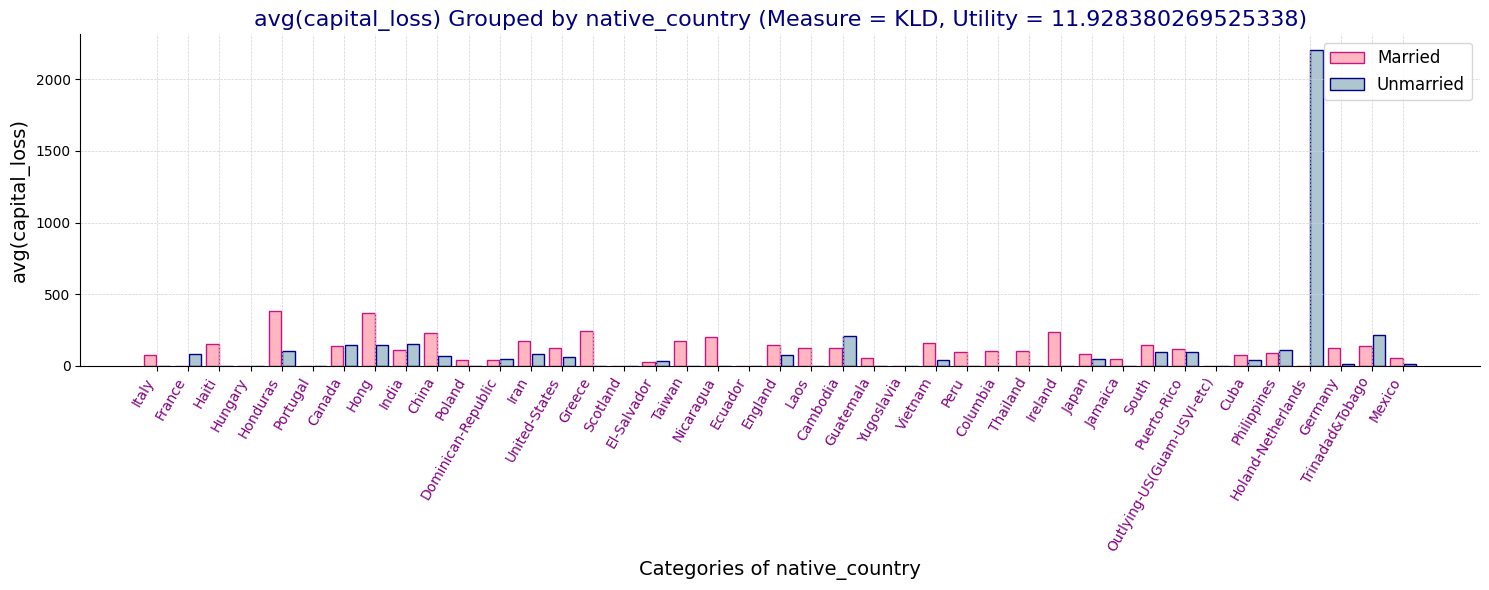

('native_country', 'max', 'capital_loss') 11.649641890739073


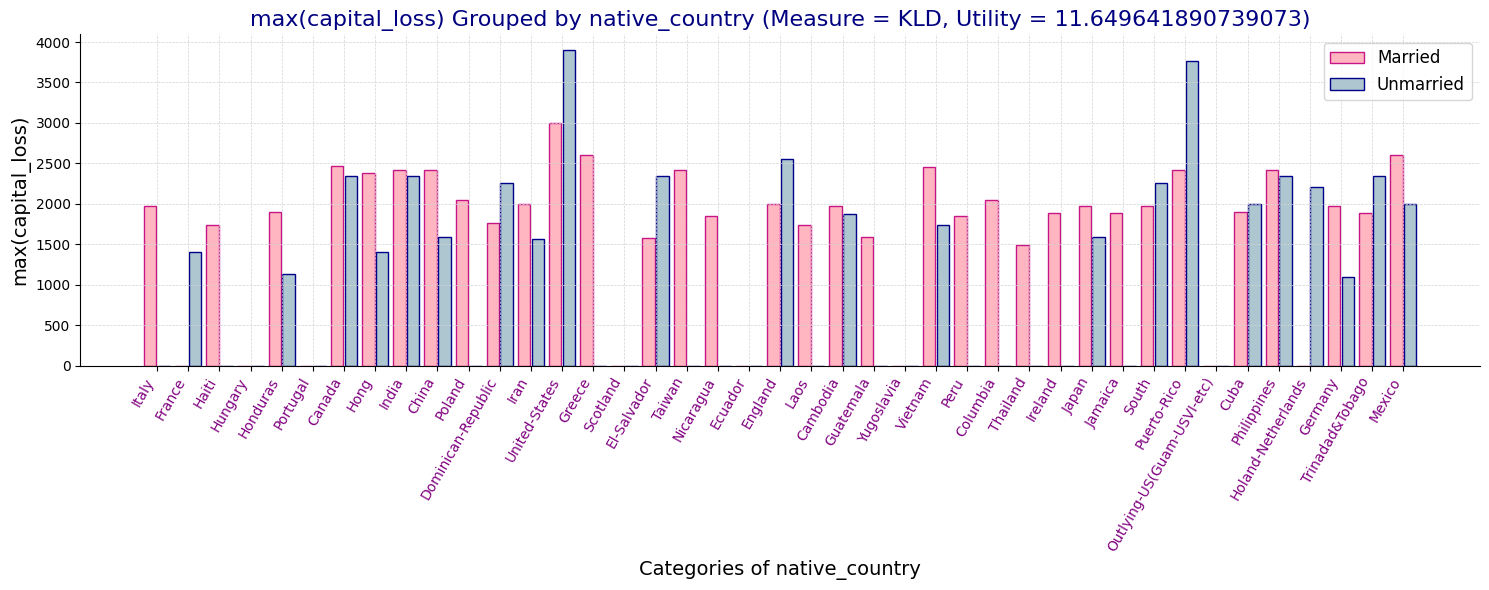

('native_country', 'avg', 'capital_gain') 7.367407353798934


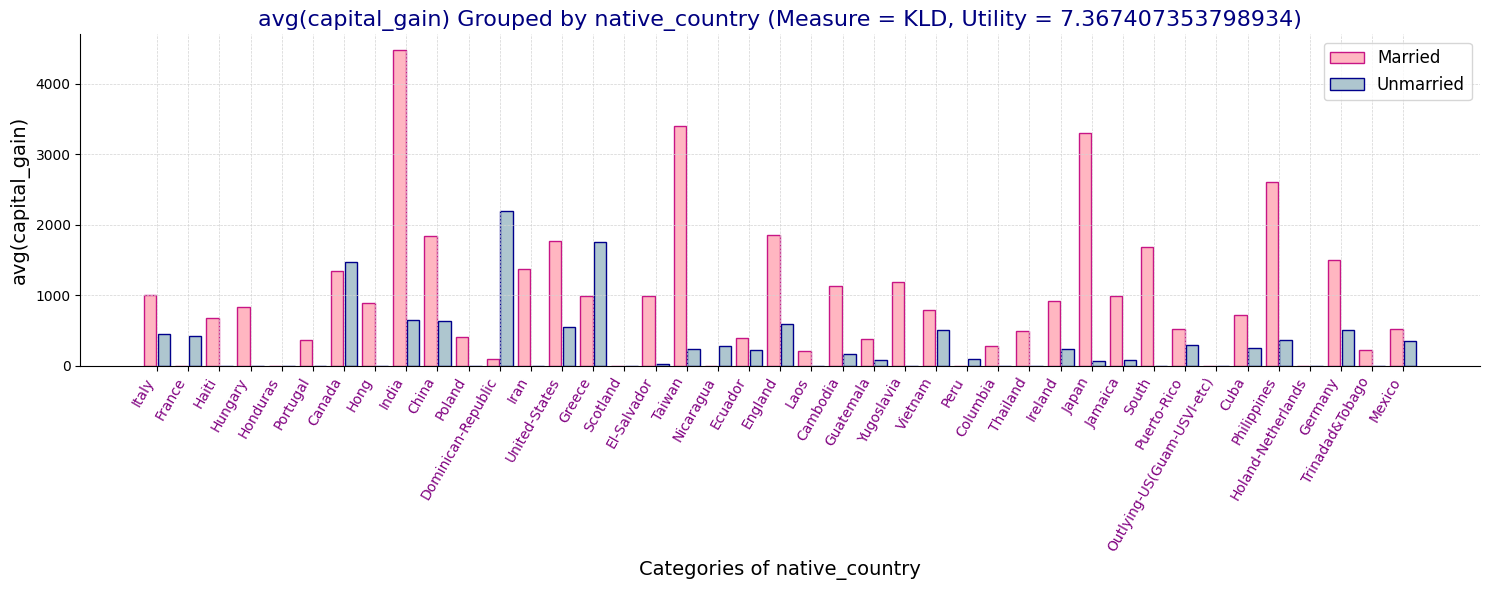

('occupation', 'avg', 'capital_loss') 6.518833732947606


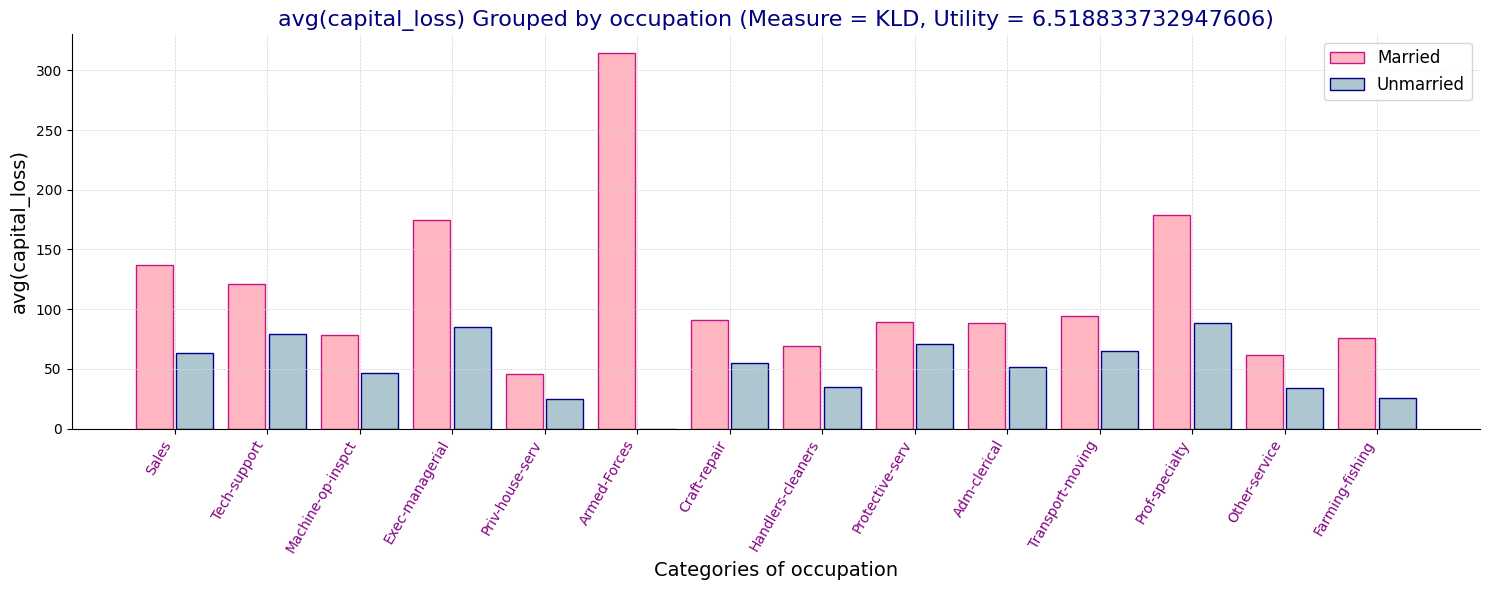

('workclass', 'avg', 'capital_loss') 4.891437460559657


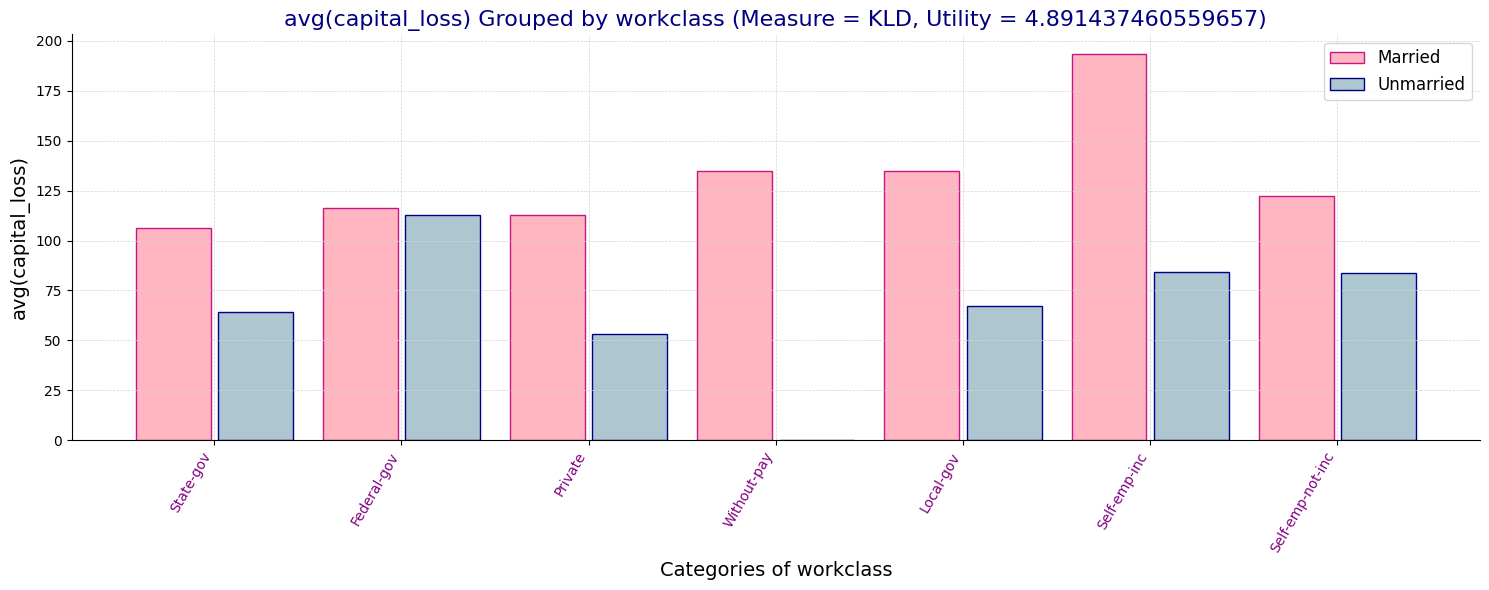

In [876]:
if __name__ == "__main__":

   
    views_ls = []
    for a in group_by_columns:
        for f in aggregation_functions:
            for m in measure_columns:
                views_ls.append((a,f,m))


    for i in range(1):
        #top_5 = pruning_based_search(cursor, views_ls,verbose=True)

        top_5 = k_sharing_based_query(cursor, views_ls)
        #top_5=naive_search(cursor,views_ls,verbose=False)
    for view, utility in top_5:
        print (view, utility)

        cursor.execute("select {g}, {f}({m}) from married group by {g};".format(g=view[0], f=view[1], m=view[2]))
        target = dict(cursor.fetchall())

        cursor.execute("select {g}, {f}({m}) from unmarried group by {g};".format(g=view[0], f=view[1], m=view[2]))
        reference = dict(cursor.fetchall())

        t = list()
        r = list()
        names = list()

        for key in set().union(target.keys(), reference.keys()):
            names.append(key)
            t_val = float(target.get(key, 0))
            r_val = float(reference.get(key, 0))
            t.append(t_val)
            r.append(r_val)
        
        visualise(view, names, utility)

    connection.commit() 

In [807]:
# cursor.close()
# connection.close()

In [808]:
# age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country